## **1. Data Preparation** 
#### Importing Libraries

In [1]:
import os
import gzip
import urllib.request
import random
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,precision_score,recall_score


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, Dataset, random_split
from torchvision import transforms
import torch.optim as optim

### **1.1 Data Loading**

In [2]:
urls = {
    "train_images": "https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz",
    "train_labels": "https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz",
    "test_images": "https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz",
    "test_labels": "https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz"
}

NOTE: Official URL dataset extract fails - http://yann.lecun.com/exdb/mnist/

In [3]:
# Function to download and extract files
def download_and_extract(url, path, is_label=False):
    if not os.path.exists(path):
        print(f"Downloading {url}...")
        urllib.request.urlretrieve(url, path)
        print(f"Downloaded {path}")
    else:
        print(f"{path} already exists, skipping download.")

    offset = 8 if is_label else 16 # Handle labels separately as their header is 8 bytes instead of 16
    with gzip.open(path, 'rb') as f:
        return np.frombuffer(f.read(), np.uint8, offset=offset)

In [4]:
def load_mnist_data():
    os.makedirs('./data', exist_ok=True)

    train_images = download_and_extract(urls['train_images'], './data/train-images.gz')
    train_labels = download_and_extract(urls['train_labels'], './data/train-labels.gz', is_label=True)
    test_images = download_and_extract(urls['test_images'], './data/test-images.gz')
    test_labels = download_and_extract(urls['test_labels'], './data/test-labels.gz', is_label=True)

    # Reshape and normalize the images
    train_images = train_images.reshape(-1, 28, 28) / 255.0
    test_images = test_images.reshape(-1, 28, 28) / 255.0

    # Combine train and test datasets for custom split
    images = np.concatenate((train_images, test_images), axis=0)
    labels = np.concatenate((train_labels, test_labels), axis=0)

    return images, labels

images, labels = load_mnist_data()
print("MNIST data downloaded and loaded.")

./data/train-images.gz already exists, skipping download.
./data/train-labels.gz already exists, skipping download.
./data/test-images.gz already exists, skipping download.
./data/test-labels.gz already exists, skipping download.
MNIST data downloaded and loaded.


### **1.2 Data Preprocessing**

In [5]:
def split_data(images, labels):
    total_size = len(images)

    # Sizes for each split
    train_size = int(0.6 * total_size)
    val_size = int(0.2 * total_size)
    test_size = total_size - train_size - val_size

    train_images, train_labels = images[:train_size], labels[:train_size]
    val_images, val_labels = images[train_size:train_size+val_size], labels[train_size:train_size+val_size]
    test_images, test_labels = images[train_size+val_size:], labels[train_size+val_size:]

    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)

# Split into training, validation, and testing sets (60%, 20%, 20%)
(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = split_data(images, labels)

print(f"Training set size: {len(train_images)}")
print(f"Validation set size: {len(val_images)}")
print(f"Test set size: {len(test_images)}")

Training set size: 42000
Validation set size: 14000
Test set size: 14000


In [6]:
class MNISTDataset(Dataset):
    def __init__(self, images, labels):
        # Convert numpy arrays to torch tensors
        self.images = torch.tensor(images, dtype=torch.float32).unsqueeze(1)
        self.labels = torch.tensor(labels, dtype=torch.long).clone().detach()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

    def get_images(self):
        return self.images

In [7]:
# Create dataset objects
train_dataset = MNISTDataset(train_images, train_labels)
val_dataset = MNISTDataset(val_images, val_labels)
test_dataset = MNISTDataset(test_images, test_labels)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

train_iter = iter(train_loader)
images, labels = next(train_iter)
print(f"Batch image shape: {images.shape}, Batch label shape: {labels.shape}")

Batch image shape: torch.Size([64, 1, 28, 28]), Batch label shape: torch.Size([64])


In [8]:
print(f"Number of rows in train_dataset: {len(train_dataset)}")
print(f"Number of rows in test_dataset: {len(test_dataset)}")
print(f"Number of rows in val_dataset: {len(val_dataset)}")

Number of rows in train_dataset: 42000
Number of rows in test_dataset: 14000
Number of rows in val_dataset: 14000


### **1.3 Data Analysis and Visualization**

#### 1.3.1 Sample Images - Visualization

In [9]:
# plot samples with labels
def plot_samples(images, labels, class_names, num_samples=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')  # Reshape to 28x28
        plt.title(f"Label: {class_names[labels[i]]}")
        plt.axis('off')

class_names = [str(i) for i in range(10)]
N = 1000  # Num of images for correlation

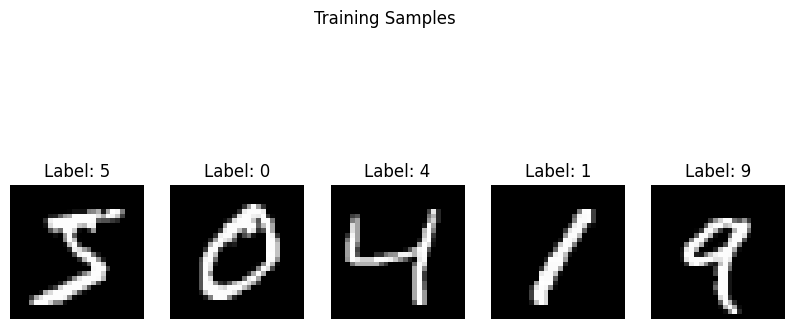

In [10]:
# Convert the first N images to a numpy array (assuming N is defined)
train_images = train_dataset.get_images().numpy()[:N]
train_labels = torch.tensor([train_dataset[i][1] for i in range(N)]).numpy()

# Plot the first N samples
plot_samples(train_images[:5], train_labels[:5], class_names, num_samples=5)
plt.suptitle('Training Samples')
plt.show()

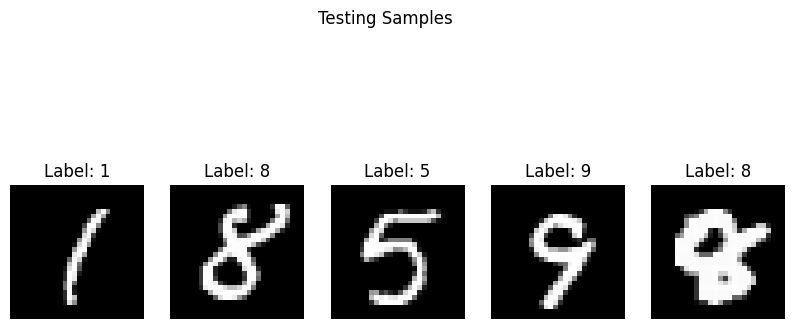

In [11]:
# Plot testing samples
test_images = torch.stack([test_dataset[i][0] for i in range(5)])
test_labels = torch.tensor([test_dataset[i][1] for i in range(5)])
plot_samples(test_images.numpy(), test_labels.numpy(), class_names, num_samples=5)
plt.suptitle('Testing Samples')
plt.show()

#### 1.3.2 Mean and Standard Deviation

<function matplotlib.pyplot.axis(arg: 'tuple[float, float, float, float] | bool | str | None' = None, /, *, emit: 'bool' = True, **kwargs) -> 'tuple[float, float, float, float]'>

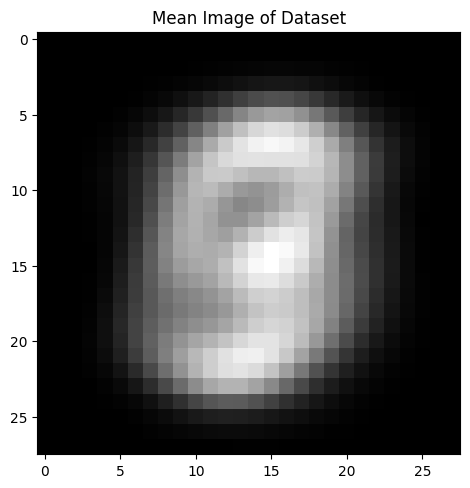

In [12]:
# Calculate mean and standard deviation across the dataset
mean_image = torch.mean(train_dataset.get_images().float(), dim=0)  # Mean of dataset
std_image = torch.std(train_dataset.get_images().float(), dim=0)    # Standard deviation of dataset

# Plot the mean and standard deviation images
plt.figure(figsize=(12, 6))

# Mean image
plt.subplot(1, 2, 1)
plt.imshow(mean_image.squeeze(), cmap='gray')  # .squeeze() to remove channel dimension for plotting
plt.title("Mean Image of Dataset")
plt.axis


#### 1.3.3 Correlation Matrix of MNIST pixel values

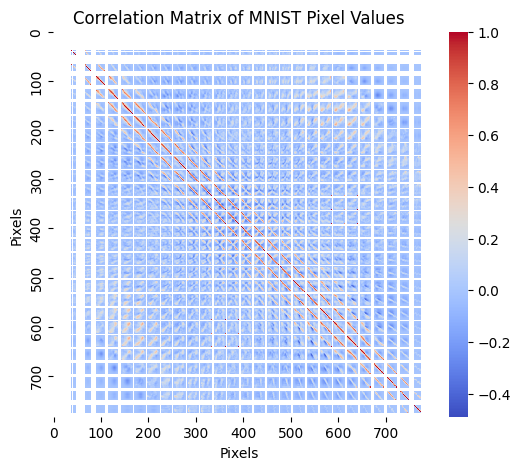

In [13]:
import warnings

train_images = torch.stack([train_dataset[i][0] for i in range(N)])
train_labels = torch.tensor([train_dataset[i][1] for i in range(N)])
train_images = train_images.view(N, -1).numpy()

warnings.filterwarnings("ignore", category=RuntimeWarning)

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(train_images.T)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, cmap='coolwarm', cbar=True, xticklabels=100, yticklabels=100)
plt.title('Correlation Matrix of MNIST Pixel Values')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.show()

#### 1.3.4 Distribution of Digits

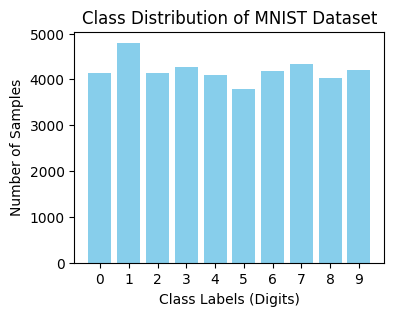

In [14]:
labels = train_dataset.labels

unique, counts = np.unique(labels.numpy(), return_counts=True)

# Create a bar plot for class distribution
plt.figure(figsize=(4, 3))
plt.bar(unique, counts, color='skyblue')
plt.title('Class Distribution of MNIST Dataset')
plt.xlabel('Class Labels (Digits)')
plt.ylabel('Number of Samples')
plt.xticks(unique)  # Set x-axis ticks to be the class labels
plt.show()

In [15]:
print(f"Total Training Samples: {len(train_dataset)}")
print(f"Total Testing Samples: {len(test_dataset)}")
print(f"Total Validation Samples: {len(val_dataset)}")
print(f"Image Shape: {train_dataset[0][0].shape}")
print(f"Number of Classes: {len(unique)}")

Total Training Samples: 42000
Total Testing Samples: 14000
Total Validation Samples: 14000
Image Shape: torch.Size([1, 28, 28])
Number of Classes: 10


#### 1.3.5 Principal Component Analysis (PCA) on dataset

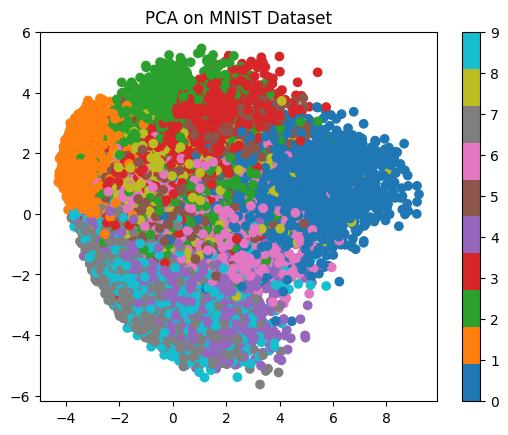

In [16]:
# Flatten the images for PCA
data = train_dataset.get_images().view(-1, 28*28).numpy()
labels = train_dataset.labels.numpy()

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='tab10')
plt.colorbar()
plt.title('PCA on MNIST Dataset')
plt.show()

### 1.4 **Data Augmentation**

#### 1.4.1 Rotating selected images in the dataset to increase the diversity in data

**Procedure**

Define the transformations to rotate the images to left and right by 15 and 5 degrees.
A function is defined to rotate and replace since the same code can be reused for training and testing.
The dataset, no of classes and the portion of data in which we are going to select are used as inputs to the function.
Inside the function, create a dictionary to store the indices of data points belonging to each class.
format of the dictionary will be like {0 :[],1:[]}.
since we are going to rotate to left by 15 and 5 and rotate tight to by 15 and 5 divide the dataset to 4 to avoid any duplicates





In [17]:
# Set random seed for reproducibility
random.seed(42)

# Define transformations for rotations
rotate_r15 = transforms.RandomRotation(degrees=(-15, -15))
rotate_r5 = transforms.RandomRotation(degrees=(-5, -5))
rotate_l15 = transforms.RandomRotation(degrees=(5, 5))
rotate_l5 = transforms.RandomRotation(degrees=(15, 15))

# Function to divide, rotate, and replace a portion of images from each class
def rotate_and_replace(dataset, selected_portion):
    # Retrieve data without reshaping
    data = dataset.get_images().numpy()

    # Initialize class_indices dynamically
    class_indices = {}
    for img_index in range(len(dataset)):
        _, label = dataset[img_index]
        label = int(label.item() if isinstance(label, torch.Tensor) else label)

        if label not in class_indices:
            class_indices[label] = []
        class_indices[label].append(img_index)

    # Apply rotations
    for indices in class_indices.values():
        num_to_rotate = int(len(indices) * selected_portion)
        selected_indices = random.sample(indices, num_to_rotate)
        quarter_size = num_to_rotate // 4

        for idx in selected_indices[:quarter_size]:
            data[idx] = (rotate_r15(dataset[idx][0]) * 255).byte().numpy()

        for idx in selected_indices[quarter_size:2 * quarter_size]:
            data[idx] = (rotate_r5(dataset[idx][0]) * 255).byte().numpy()

        for idx in selected_indices[2 * quarter_size:3 * quarter_size]:
            data[idx] = (rotate_l15(dataset[idx][0]) * 255).byte().numpy()

        for idx in selected_indices[3 * quarter_size:]:
            data[idx] = (rotate_l5(dataset[idx][0]) * 255).byte().numpy()

    # Update dataset with transformed data
    dataset.data = torch.from_numpy(data)
    return dataset

Apply for the training set

In [18]:
train_dataset = rotate_and_replace(train_dataset, 0.2)
test_dataset = rotate_and_replace(test_dataset, 0.2)
val_dataset = rotate_and_replace(val_dataset, 0.2)

In [19]:
print(f"Total Training Samples: {len(train_dataset)}")
print(f"Total Testing Samples: {len(test_dataset)}")
print(f"Total Validation Samples: {len(val_dataset)}")

Total Training Samples: 42000
Total Testing Samples: 14000
Total Validation Samples: 14000


Test output after rotating

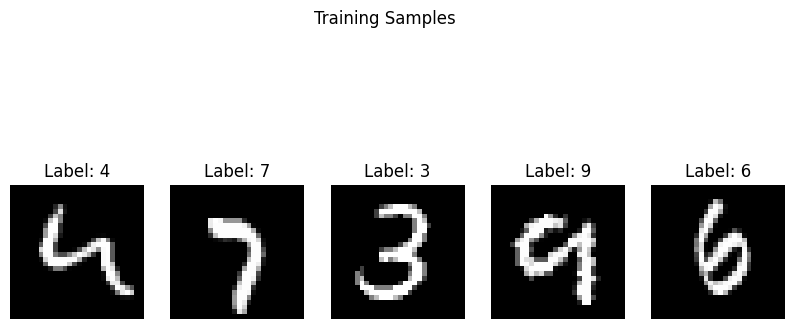

In [20]:
num_samples = 5  # Randomly select indices from the training dataset
train_indices = random.sample(range(len(train_dataset)), num_samples)

train_images = torch.stack([train_dataset[i][0] for i in train_indices])
train_labels = torch.tensor([train_dataset[i][1] for i in train_indices])

plot_samples(train_images[:5], train_labels[:5], class_names, num_samples=5)
plt.suptitle('Training Samples')
plt.show()

## **2. Model Building** 

### **2.1 Model Creation**

##### **Architecture**

The `CustomCNN` class defines a Convolutional Neural Network (CNN) for image classification task

1. First Convolutional Block - Uses 32 filters of size 3x3 to apply a single-channel greyscale image. MaxPooling reduces the spatial dimensions by a factor of 2

2. Second Convolutional Block - Takes the 32-channel input from the previous layer and applies 64 filters of size 3x3. MaxPooling Layer reduces the spatial dimensions further

3. Fully Connected Layer - Flattens feature maps into a fully connected layer with 128 neurons. The dropout layer prevents overfitting.

4. Output Layer - Maps the 128-dimensional input to the number of classes.

#### **Forward Propagation**

The forward propagation method involves applying the first convolutional block, followed by ReLU activation and max pooling. The second convolutional block is applied, followed by ReLU activation and max pooling. The feature maps are flattened into a 1D tensor for the fully connected layer. The fully connected layer is applied, followed by ReLU activation. Dropout is applied to prevent overfitting. The output layer is used to produce class scores and convert them into log-probabilities using the log-softmax function.

In [21]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.5):
        super(CustomCNN, self).__init__()

        # First Convolutional Block - Convolution with 32 filters and MaxPooling
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Convolutional Block - Convolution with 64 filters and MaxPooling
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layer
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(dropout_rate)

        # Final output layer with softmax
        self.fc2 = nn.Linear(128, num_classes)

    #Forward Propagation
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))

        x = self.pool2(F.relu(self.conv2(x)))

        x = x.view(-1, 64 * 7 * 7)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = CustomCNN(num_classes=10, dropout_rate=0.5)
print(model)

CustomCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


Run `pip install torchview` and `sudo apt-get install graphviz`

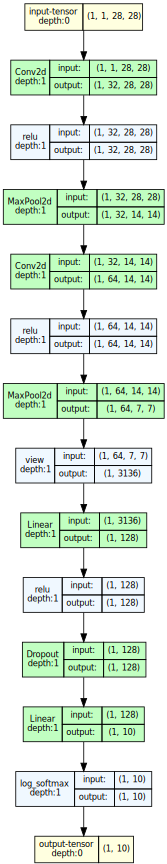

In [22]:
from torchview import draw_graph

example_input = torch.rand(1, 1, 28, 28)  # MNIST images are 28x28 with 1 channel

# Draw the model graph
model_graph = draw_graph(model, example_input, expand_nested=True, graph_name='CustomCNN')
model_graph.visual_graph

### **2.2  Model Training** 


In [23]:
# Hyperparameters
epochs = 20
learning_rate = 0.001

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate)

#Initialize Losses
train_losses = []
val_losses = []

for epoch in range(epochs):
    # Training model
    model.train()
    train_loss = 0.0
    model.to('cpu')

    # Calculation of training losses
    for images,labels in train_loader:
        optimizer.zero_grad()
        images , labels = images.to("cpu"), labels.to('cpu')
        outputs = model(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()

    # Validating model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
    # Calculation of validation losses
        for images,labels in val_loader:
            images, labels = images.to('cpu'), labels.to('cpu')
            outputs = model(images)
            loss = criterion(outputs,labels)
            val_loss += loss.item()

    # Average losses for the epoch
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch:{epoch+1}    Training Loss: {train_loss:.4f} Validation Loss: {val_loss:.4f} ")


Epoch:1    Training Loss: 1.0142 Validation Loss: 0.3363 
Epoch:2    Training Loss: 0.4112 Validation Loss: 0.2038 
Epoch:3    Training Loss: 0.2963 Validation Loss: 0.1524 
Epoch:4    Training Loss: 0.2356 Validation Loss: 0.1439 
Epoch:5    Training Loss: 0.2024 Validation Loss: 0.1248 
Epoch:6    Training Loss: 0.1950 Validation Loss: 0.1510 
Epoch:7    Training Loss: 0.1782 Validation Loss: 0.1148 
Epoch:8    Training Loss: 0.1574 Validation Loss: 0.1103 
Epoch:9    Training Loss: 0.1463 Validation Loss: 0.1048 
Epoch:10    Training Loss: 0.1389 Validation Loss: 0.1305 
Epoch:11    Training Loss: 0.1365 Validation Loss: 0.0936 
Epoch:12    Training Loss: 0.1209 Validation Loss: 0.0924 
Epoch:13    Training Loss: 0.1161 Validation Loss: 0.1230 
Epoch:14    Training Loss: 0.1188 Validation Loss: 0.1265 
Epoch:15    Training Loss: 0.1150 Validation Loss: 0.1145 
Epoch:16    Training Loss: 0.1091 Validation Loss: 0.1166 
Epoch:17    Training Loss: 0.1054 Validation Loss: 0.1084 
Epoch:

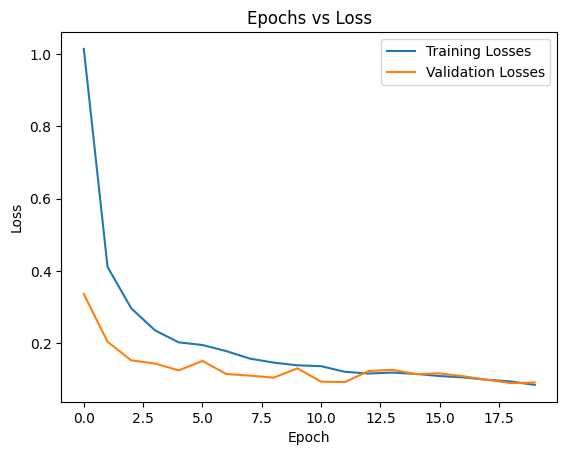

In [24]:
# Plotting Training and validation losses
plt.plot(train_losses, label  = "Training Losses")
plt.plot(val_losses , label = 'Validation Losses')
plt.xlabel("Epoch")
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.legend()
plt.show()

In [26]:
torch.save(model.state_dict(), 'model/custom_cnn_model.pth')

### **2.3 Model Evaluation**

In [25]:
from sklearn.metrics import accuracy_score

# Evaluate model on the test dataset
model.eval()
test_loss = 0.0
all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient tracking for evaluation
    for images, labels in test_loader:
        images, labels = images.to("cpu"), labels.to("cpu")
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Store predictions and true labels
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate average test loss
test_loss /= len(test_loader)

# Calculate accuracy
test_accuracy = accuracy_score(all_labels, all_preds)

# Calculate confusion matrix, precision, and recall
conf_matrix = confusion_matrix(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')

# Print results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Test Loss: 0.0847
Test Accuracy: 0.9818
Confusion Matrix:
 [[1362    0    1    1    1    0    1    1    3    3]
 [   0 1562    2    1    0    0    2    2    0    0]
 [   2    0 1413    6    2    0    0    2    4    1]
 [   1    0    6 1387    0   11    0    4    3    1]
 [   0    3    0    0 1352    0    0    2    4   15]
 [   3    0    0   13    0 1221    7    0    6    3]
 [  12    3    0    0    5    4 1313    0    2    0]
 [   0    4    9    4    2    0    0 1454    1    9]
 [  11    3   10    3    3    2    1    1 1323    8]
 [   4    3    0    5    9    9    1    4    6 1358]]
Precision: 0.9817
Recall: 0.9815
